# ld558 Computational Exercises
##Exercise 1: The Driven Pendulum
The driven pendulum problem is described by an ODE in the following form when using dot notation to signify the time differentials:

$$\ddot \theta + q \dot \theta + \frac{g}{l} \sin \theta = F \sin \left ( \Omega_D t \right ).$$


Rewriting this second-order differential equation as a pair of coupled first-order equations yields the following: 

$$\frac{\text{d}}{\text{d}t} \begin{pmatrix} y_0 \\ y_1 \end{pmatrix} = \begin{pmatrix} y_1 \\ - \frac{g}{l}\sin (y_0) - q y_1 + F \sin \left ( \Omega_D t \right ) \end{pmatrix}.$$

where $$ y_0 = \theta, y_1 = \dot \theta $$

These now coupled first order ODEs can be solved using the SciPy integrate function. Hence, approaching this from an objected oriented perspective, we define a class 'DrivenPendulumSolver' to generate a solution for this driven pendulum problem:


The class 'DrivenPendulumSolver' takes the arguments 'q' as $q$ (the dampening coefficient), 'F' as $F$ (the driving force) and 'theta0' as $\theta_0$ (the initial position). When these arguments are passed to the constructor, the ODEs are integrated and the system is solved
over a specified amount of time

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

class DrivenPendulumSolver:
  """Class for solving the driven pendulum problem. Takes arguments of q, F and then theta0 over a specified
  amount of time and integrates. At each point of the oscillation, the energy is also calculated"""

  def __init__(self,q,F,theta0):
    self.q = q
    self.F = F
    self.theta0 = theta0
    self.omegad = 2/3 #driving angular frequnecy, given in the question
    self.t = None #time
    self.theta = None #angular position at current time
    self.dtheta = None #angular speed at time 
    self.E = None #energy
    self.solution = None 

  def compute_E(self):
    """Computes the energy of the pendulum"""
    self.E = (1-(np.cos(self.theta))) + (0.5*(self.dtheta**2))   #gpe term looks like this as g=l given in question

  def integrate(self, t, increments=None):
    """Performs integration of the ODES and outputs time and the angular positon and velocity."""
    #defining the ode for use in the scipy.integrate function
    ode = lambda t,y : [y[1], -np.sin(y[0]) - self.q*y[1] + self.F*np.sin(self.omegad*t)]
    t_eval = None
    max_step = np.inf
    
    if increments != None:
      t_eval = np.linspace(0,t,increments)
      maximum_increment = t/increments
    
    solution = scipy.integrate.solve_ivp(ode, [0,t], [self.theta0, 0], method='RK45', t_eval = t_eval, max_step=max_step)
    
    self.t = solution.t
    self.theta = solution.y[0]
    self.dtheta = solution.y[1]
    self.solution = solution
    self.compute_E()



#Solution to Core Task 1
#Pendulum with No Driving and No Damping

Over 10 to 1000 natural periods of oscillation, comparison between the computational solution and that of the expected theoretical result for small-angle oscillations show good agreement. Using a small increment size allows for the relative phases to not drift in time for a large number of periods. 

It is also shown below that for a 10000 period of oscillation, the RK4 method used by the scipy.integrate function causes a slow drift in energy from the theory over time.

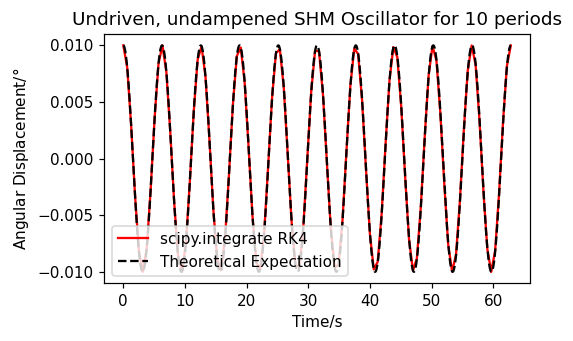

In [ ]:
#Adjusting the scaling of the plots such that they're readable
matplotlib.rcParams['figure.dpi'] = 110

# Comparing small oscillations with the initial conditions as defined in the booklet
undrivenpend = DrivenPendulumSolver(0,0,0.01)
undrivenpend.integrate(2*np.pi*10, 100)

#Creating the plot for the case of 10 periods
plt.figure(1, figsize=(5,3))
plt.xlabel('Time/s')
plt.ylabel('Angular Displacement/$\degree$')
plt.plot(undrivenpend.t, undrivenpend.theta, label='scipy.integrate RK4', color='red')
timespace = np.linspace(0,2*np.pi*10, 1000)
plt.plot(timespace, 0.01*np.cos(timespace), '--', label='Theoretical Expectation', color='black')
plt.title('Undriven, undampened SHM Oscillator for 10 periods')
plt.legend(loc='lower left')


As can be seen, good agreement is shown for small angles between RK4 computationally and the theoretical expectation for small angle oscillations

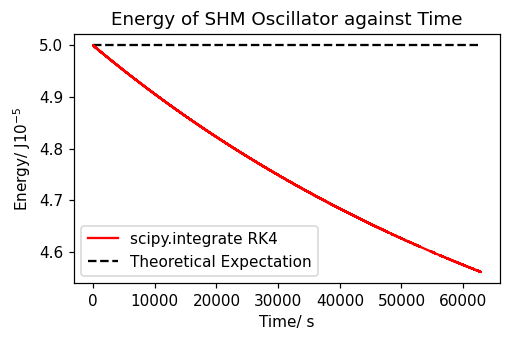

In [ ]:
# See how well the RK4 method conserves energy.
undrivenpend = DrivenPendulumSolver(0,0,0.01)
undrivenpend.integrate(2*np.pi*10000)
plt.figure(2, figsize=(5,3))
plt.xlabel('Time/ s')
plt.ylabel('Energy/ J$10^{-5}$')
plt.plot(undrivenpend.t, 1e5*undrivenpend.E, label='scipy.integrate RK4', color='red')
plt.plot([0, max(undrivenpend.t)], [1e5*(1-np.cos(0.01))]*2, '--', label='Theoretical Expectation', zorder=-1,color='black')
plt.title('Energy of SHM Oscillator against Time')
plt.legend(loc='lower left')


plt.show()

The above shows slow drift in energy against theory for the RK4 method for 10000 oscillations.

Plotting the period as a function of amplitude and using this to determine the value for the period at an angular displacement $\theta_0 = \fracπ2$.

In [ ]:
# Find period as a function of amplitude.
minimum_theta = 0.01
maximum_theta = np.pi - 0.01
steps_theta = 1000
theta_values = np.linspace(minimum_theta, maximum_theta, steps_theta)
periods = np.zeros(steps_theta)

for i in range(len(theta_values)):
    thet = theta_values[i]

    #Prevents the computation failing when finding a previous period that is too long.
    if i>1 and periods[i-1] == np.inf:
        periods[i] = np.inf
        continue
    # Using liner inerpolation, we can approximate the period so we know how many inccrement to integrate for. we use the past two periods for the approximation
    next_period = 2*np.pi
    if i>1:
        next_period = 2*periods[i-1] - periods[i-2]

    # Run simulation for 1.5 times the period estimate.
    pend = DrivenPendulumSolver(0,0,thet)
    pend.integrate(1.5*next_period, 50)
    
    # One period occurs when theta dot goes from a positive value to a negative
    # value for the first time. Use linear interpolation to get the period from 
    # d_theta crossing the t-axis.
    idcs = np.asarray((pend.dtheta[0:-1] > 0)*(pend.dtheta[1:] <= 0)).nonzero()
    if (len(idcs[0]) == 0):
        print(f'Failed to get period for th = {thet/np.pi}pis.')
        periods[i] = np.inf
        continue

    idx = idcs[0][0]
    abv = pend.dtheta[idx]
    blw = pend.dtheta[idx+1]
    periods[i] = pend.t[idx] + abv/(abv-blw)*(pend.t[idx+1] - pend.t[idx])

# Plot period as a function of amplitude.
plt.figure(3, figsize=(4,3))
plt.plot(theta_values, periods)
plt.title('Pendulum Period vs Amplitude')
plt.xlabel('Amplitude / rad')
plt.ylabel('Period / rad s$^{-1}$')

plt.show()

if steps_theta % 2 == 0:
    half_pi_period = (periods[int(np.floor((steps_theta-1)/2))] + periods[int(np.ceil((steps_theta,-1)/2))]) /2 
else:
    half_pi_period = periods[int((steps_theta-1)/2)]

print(f'At initial angle = pi/2, the period is {half_pi_period:0.3f}.')

Failed to get period for th = 0.957031763909881pis.


/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


KeyboardInterrupt: ignored